In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(42)

# Portfolio Planner

In this activity, you will use the iexfinance api to grab historical data for a 60/40 portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [58]:
import alpaca_trade_api as tradeapi

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
# Initialize the API
api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

# Data Collection

In this step, you will need to use the IEX api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [59]:
tickers = ["SPY", "AGG"]
timeframe = "1D"
end_date = datetime.now()
start_date = end_date + timedelta(252)
combo_df = api.get_barset(
    tickers,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

combo_df.head

<bound method NDFrame.head of                               AGG                                          \
                             open      high       low     close    volume   
2019-11-18 00:00:00-05:00  112.56  112.6460  112.5200  112.5950   5550696   
2019-11-19 00:00:00-05:00  112.63  112.7600  112.6000  112.7100   2181200   
2019-11-20 00:00:00-05:00  112.83  112.9800  112.8050  112.9700   3218845   
2019-11-21 00:00:00-05:00  112.80  112.8859  112.7200  112.8131   3971410   
2019-11-22 00:00:00-05:00  112.89  112.9000  112.7605  112.8500   2233649   
...                           ...       ...       ...       ...       ...   
2020-04-06 00:00:00-04:00  115.02  115.6100  115.0200  115.5800  13270754   
2020-04-07 00:00:00-04:00  115.54  115.7400  115.3600  115.6900  10415760   
2020-04-08 00:00:00-04:00  115.70  115.9700  115.5500  115.8100   8598048   
2020-04-09 00:00:00-04:00  116.50  117.2500  116.1700  117.1100   8244166   
2020-04-13 00:00:00-04:00  117.09  117.1700  1

In [60]:
combo_df.drop(columns=['open', 'high', 'low', 'volume'], level=1, inplace=True)
combo_df.head()

,AGG,SPY
,close,close
2019-11-18 00:00:00-05:00,112.5950,312.00
2019-11-19 00:00:00-05:00,112.7100,311.91
2019-11-20 00:00:00-05:00,112.9700,310.79
2019-11-21 00:00:00-05:00,112.8131,310.29
2019-11-22 00:00:00-05:00,112.8500,311.00


# Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:
1. Calculate the daily returns for the SPY and AGG closing prices.
2. Calculate volatility for both the SPY and AGG closing prices.
3. Find the last day's closing price for both stocks and save those as variables.
4. Run a Monte Carlo Simulation of at least 500 iterations and generate at least 30 years of closing prices

### HINTS:
There are 252 trading days per year, so the number of records to generate for each Monte Carlo run will be 252 days * 30 years

In [61]:
# Calculate the daily roi for the stocks
daily_returns = combo_df.pct_change()
daily_returns.head()

,AGG,SPY
,close,close
2019-11-18 00:00:00-05:00,NaN,NaN
2019-11-19 00:00:00-05:00,0.001021,-0.000288
2019-11-20 00:00:00-05:00,0.002307,-0.003591
2019-11-21 00:00:00-05:00,-0.001389,-0.001609
2019-11-22 00:00:00-05:00,0.000327,0.002288


In [62]:
avg_daily_return_agg = daily_returns.mean()['AGG']['close']
avg_daily_return_spy = daily_returns.mean()['SPY']['close']
print(f" AGG Average Daily Return: {avg_daily_return_agg}")
print(f" SPY Average Daily Return: {avg_daily_return_spy}")

 AGG Average Daily Return: 0.00039952550793326437
 SPY Average Daily Return: -0.0008053578222638612


In [63]:
# Calculate volatility
std_dev_daily_return_agg = daily_returns.std()['AGG']['close']
std_dev_daily_return_spy = daily_returns.std()['SPY']['close']
print(f" AGG Standard Deviation: {std_dev_daily_return_agg}")
print(f" SPY Standard Deviation: {std_dev_daily_return_spy}")

 AGG Standard Deviation: 0.008486930467479845
 SPY Standard Deviation: 0.029950975941050197


In [64]:
# Save the last day's closing price
spy_last = combo_df["SPY"]["close"][-1]
agg_last = combo_df["AGG"]["close"][-1]
print(spy_last)
print(agg_last)

275.57
116.72


In [88]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252*30
monte_carlo = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

In [89]:
# Run the Monte Carlo Simulation

for n in range(number_simulations):

    simulated_agg_prices = [agg_last]
    simulated_spy_prices = [spy_last]
    
    for i in range(number_records):
        
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_return_agg, std_dev_daily_return_agg))
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_return_spy, std_dev_daily_return_spy))
        
        simulated_agg_prices.append(simulated_agg_price)
        simulated_spy_prices.append(simulated_spy_price)
    
    monte_carlo["AGG Prices"] = pd.Series(simulated_agg_prices)
    monte_carlo["SPY Prices"] = pd.Series(simulated_spy_prices)
    
    simulated_daily_returns = monte_carlo.pct_change()
    
    weights = [0.40, 0.60]
    
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()
    
portfolio_cumulative_returns.head() 


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.966350,0.995066,0.969285,1.029984,1.003349,1.005808,1.001580,0.995955,0.996111,1.001439,...,1.017887,0.991765,1.004188,0.982348,0.986549,1.006479,0.986987,1.027118,1.032586,1.005098
2,0.974060,0.996005,0.980783,0.997318,0.988957,0.999714,1.027745,1.001983,0.986337,0.972772,...,1.004358,1.019843,1.007502,0.988244,0.986364,1.015129,1.001135,1.027852,1.032839,1.002583
3,0.976945,0.981937,0.995610,1.026394,0.987386,1.008965,1.007170,0.992081,0.962179,0.977340,...,1.009092,1.046185,1.020226,1.016449,0.955278,1.020115,1.005677,1.033571,1.051825,0.998472
4,0.954962,0.994041,0.972195,1.014580,0.978992,1.032316,1.002814,0.974503,0.966321,0.988430,...,1.055949,1.046947,1.013374,1.027408,0.960388,0.999016,1.006014,1.041938,1.031608,1.008630


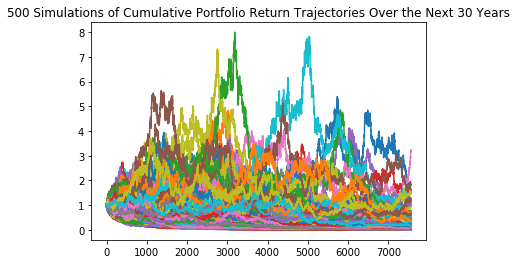

In [91]:
# Visualize the Simulation
plot_title = f"{n+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next 30 Years"
portfolio_cumulative_returns.plot(legend=None, title=plot_title)

In [103]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
ending_cumulative_returns_30 = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns_30

0      0.054726
1      0.001289
2      0.083764
3      0.575805
4      0.029524
         ...   
495    1.296603
496    0.079897
497    0.009227
498    1.524520
499    0.159689
Name: 7560, Length: 500, dtype: float64

In [104]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
ending_cumulative_returns_20 = portfolio_cumulative_returns.iloc[-(10 * 252), :]
ending_cumulative_returns_20

0      0.044732
1      0.079146
2      0.348510
3      2.012945
4      0.145585
         ...   
495    0.616649
496    0.086973
497    0.058794
498    0.882501
499    0.271044
Name: 5041, Length: 500, dtype: float64

0.05    0.001878
0.95    0.495267
Name: 7560, dtype: float64

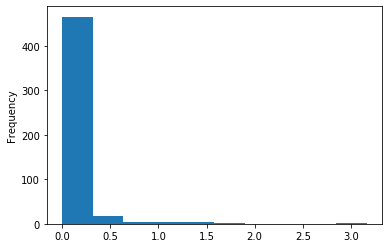

In [109]:
# Display the 90% confidence interval for the ending returns in 30 Years
ending_cumulative_returns_30.plot(kind='hist', bins=10)
ending_cumulative_returns_30.value_counts(bins=11) / len(ending_cumulative_returns)
confidence_interval = ending_cumulative_returns_30.quantile(q=[0.05, 0.95])
confidence_interval

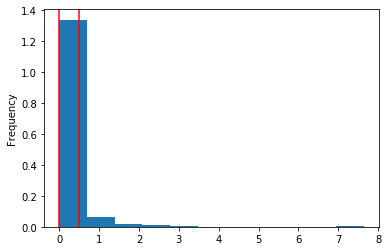

In [110]:
# Visualize the distribution of the ending returns
plt.figure();
ending_cumulative_returns.plot(kind='hist', density=True, bins=11)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

---

# Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?
2. Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?
3. Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?
4. How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

0.5    0.027987
0.5    0.027987
Name: 7560, dtype: float64

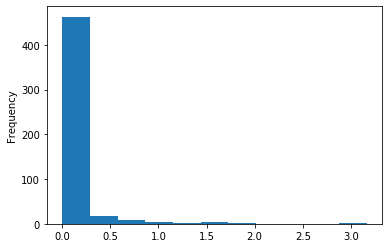

In [113]:
# 30 Years 50th percentile
ending_cumulative_returns_30.plot(kind='hist', bins=11)
ending_cumulative_returns_30.value_counts(bins=11) / len(ending_cumulative_returns)
confidence_interval = ending_cumulative_returns_30.quantile(q=[0.5, 0.5])
confidence_interval

# 30 years 90th and 10th percentile
ending_cumulative_returns_30.plot(kind='hist', bins=11)
ending_cumulative_returns_30.value_counts(bins=11) / len(ending_cumulative_returns)
confidence_interval = ending_cumulative_returns_30.quantile(q=[0.1, 0.9])

### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [102]:
initial_investment = 20000

# Calculate investment profit/loss of lower and upper bound cumulative portfolio returns
investment_pnl_lower_bound = initial_investment + (initial_investment * confidence_interval.iloc[0])
investment_pnl_upper_bound = initial_investment + (initial_investment * confidence_interval.iloc[1])
                                                    
# Print the results
print(f"There is a 90% chance that an initial investment of $20,000 in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${investment_pnl_lower_bound} and ${investment_pnl_upper_bound}")

There is a 90% chance that an initial investment of $20,000 in the portfolio over the next 30 years will end within in the range of $20072.126090997757 and $24338.423737228102


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [ ]:
# YOUR CODE HERE

### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [ ]:
# YOUR CODE HERE

### Optional Challenge

In this section, you will calculate and plot the cumulative returns for the median and 90% confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [119]:
# for n in range(number_simulations):
#     simulated_agg_prices = [agg_last]
#     simulated_spy_prices = [spy_last]
    
# #     for i in range(number_records):
# #         simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_return_agg, std_dev_daily_return_agg))
# #         simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_return_spy, std_dev_daily_return_spy))
        
# #         simulated_agg_prices.append(simulated_agg_price)
# #         simulated_spy_prices.append(simulated_spy_price)
    
    
    
# #     monte_carlo["AGG Prices"] = pd.Series(simulated_agg_price)
# #     monte_carlo["SPY Prices"] = pd.Series(simulated_spy_price)
    
    
    
#     for i in range(number_records):
        
#         simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_return_agg, std_dev_daily_return_agg))
#         simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_return_spy, std_dev_daily_return_spy))
        
#         simulated_agg_prices.append(simulated_agg_price)
#         simulated_spy_prices.append(simulated_spy_price)
    
#     monte_carlo["AGG Prices"] = pd.Series(simulated_agg_prices)
#     monte_carlo["SPY Prices"] = pd.Series(simulated_spy_prices)
    
# #     simulated_daily_returns = monte_carlo.pct_change()
    
# #     weights = [0.4, 0.6]
    
# #     portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
# #     portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()
    
# # portfolio_cumulative_returns.head() 

# monte_carlo